In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')
#:::::::::::::::::::::::::::::::::::
import os
import gc
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from itertools import groupby
#:::::::::::::::::::::::::::::::::::
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
# ???
#!ls ../input/*


In [2]:
# 캐글 실행용
# train = pd.read_csv('../input/playground-series-s3e23/train.csv', index_col='id')
# test = pd.read_csv('../input/playground-series-s3e23/test.csv', index_col='id')
# df_sample = pd.read_csv('../input/playground-series-s3e23/sample_submission.csv')
# original_data = pd.read_csv('../input/software-defect-prediction/jm1.csv')

# 로컬

train = pd.read_csv('./playground-series-s3e23/train.csv', index_col='id')
test = pd.read_csv('./playground-series-s3e23/test.csv', index_col='id')
df_sample = pd.read_csv('./playground-series-s3e23/sample_submission.csv')
original_data = pd.read_csv('./software-defect-prediction/jm1.csv')


In [3]:
features = [f for f in train.columns.tolist() if f !='defects']
# len(features)

X = train[features]
y = train['defects']

test = test[features].copy()


# AUC

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def roc_auc(true_list, pred_list, figlen):

    fpr, tpr, _ = roc_curve(true_list, pred_list)
    roc_auc = auc(fpr, tpr)
    print(f'\nROC_AUC: %0.6f\n' %roc_auc)

    if (figlen > 0):
        sns.set()
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(figlen, figlen), facecolor='lightyellow')
        plt.gca().set_facecolor('lightgray')
        plt.fill_between(fpr, tpr, color='r', alpha=0.1)
        plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('The area under the ROC curve\n', fontsize=16, c='darkred')
        plt.legend(loc="lower right")
        plt.show()


# Gaussian Naive Bayes (GaussianNB)

In [5]:
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import QuantileTransformer


In [6]:
transformed = pd.DataFrame(QuantileTransformer(output_distribution='normal').fit_transform(X))

pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X, y)

cross_val_score(pipeline, X, y, scoring='roc_auc', cv=10).mean()


0.7575011963484038


ROC_AUC: 0.757586



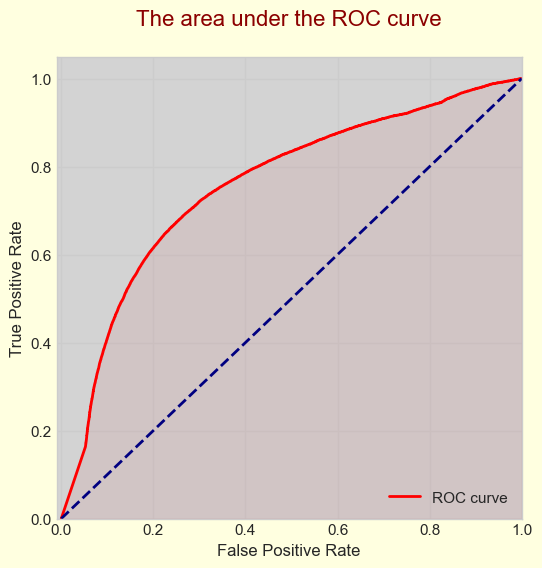

In [7]:
roc_auc(y, pipeline.predict_proba(X)[:,1], 6)


(1.401129925630331e-09, 1.0)

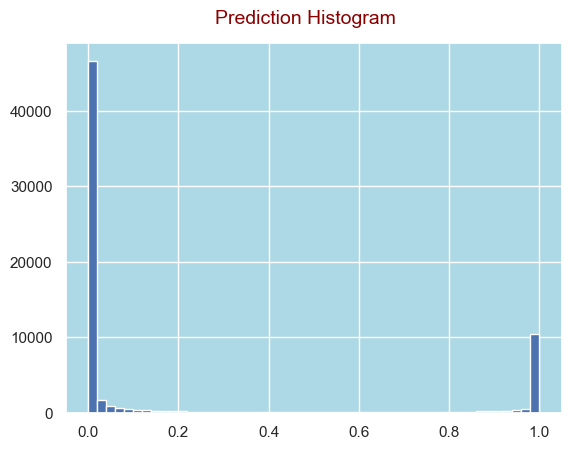

In [8]:
preds_bayes = pipeline.predict_proba(test)[:,1]

sns.set()
plt.hist(preds_bayes, bins=50)
plt.gca().set_facecolor('lightblue')
plt.suptitle('Prediction Histogram', y=0.95, fontsize=14, c='darkred')

min(preds_bayes), max(preds_bayes)


In [9]:
sub1 = df_sample.copy()
sub1['defects'] = preds_bayes
sub1.to_csv('submission1.csv',index=False)


# LightGBM

In [10]:
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


In [11]:
def lgbm_cl_bo(min_child_samples, colsample_bytree, learning_rate, num_leaves, reg_alpha, reg_lambda):

    params_lgbm = {}
    params_lgbm['min_child_samples'] = round(min_child_samples)
    params_lgbm['colsample_bytree'] = colsample_bytree
    params_lgbm['learning_rate'] = learning_rate
    params_lgbm['num_leaves'] = round(num_leaves)
    params_lgbm['reg_alpha'] = reg_alpha
    params_lgbm['reg_lambda'] = reg_lambda

    params_lgbm['boosting_type'] ='gbdt'   # Manual optimization
    params_lgbm['objective'] ='binary'     # Manual optimization
    params_lgbm['subsample'] = 1.0
    params_lgbm['max_bin'] = 1023
    params_lgbm['n_jobs'] = -1

    scores = cross_val_score(LGBMClassifier(**params_lgbm, random_state=2920), X, y, scoring='roc_auc', cv=5).mean()
    score = scores.mean()
    return score


In [12]:
params_lgbm ={'min_child_samples':(800, 1200),
              'colsample_bytree':(0.3, 1.0),
              'learning_rate':(0.005, 0.1),
              'num_leaves':(20, 60),
              'reg_alpha':(0.0, 10.0),
              'reg_lambda':(0.0, 5.0)}

lgbm_bo = BayesianOptimization(lgbm_cl_bo, params_lgbm, random_state=2920)
lgbm_bo.maximize(n_iter=30, init_points=20)


|   iter    |  target   | colsam... | learni... | min_ch... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7916    | 0.9111    | 0.05009   | 887.4     | 47.75     | 7.915     | 1.226     |
| 2         | 0.7915    | 0.9502    | 0.06947   | 833.5     | 44.51     | 2.255     | 1.838     |
| 3         | 0.7918    | 0.4816    | 0.07103   | 1.027e+03 | 38.75     | 5.368     | 1.941     |
| 4         | 0.7919    | 0.9072    | 0.05826   | 824.2     | 27.11     | 4.494     | 2.04      |
| 5         | 0.7894    | 0.4835    | 0.01853   | 927.6     | 34.94     | 9.711     | 4.751     |
| 6         | 0.789     | 0.9807    | 0.009078  | 1.083e+03 | 39.49     | 6.385     | 0.6945    |
| 7         | 0.791     | 0.7085    | 0.02226   | 1.084e+03 | 49.88     | 0.6991    | 4.858     |
| 8         | 0.792     | 0.3928    | 0.08767   | 1.181e+03 | 42.19     | 7.881     | 2.85      |
| 9         | 0.7902

In [13]:
#pmax_bayes = lgbm_bo.max['params']
#pmax_bayes

pmax_bayes = {'colsample_bytree': 0.4163311349218529,
 'learning_rate': 0.08228459494144628,
 'min_child_samples': 1135.635076353881,
 'num_leaves': 27.081231918031968,
 'reg_alpha': 7.7721348779841595,
 'reg_lambda': 4.86179306834822}


In [14]:
model = LGBMClassifier(n_estimators= 20000,
                       learning_rate= 0.07,
                       objective= 'binary',
                       boosting_type= 'gbdt',

                       subsample= 1.0,
                       num_leaves= 23,
                       max_bin= 1023,
                       n_jobs= -1,

                       reg_alpha= 0.65,
                       reg_lambda= 3.1,
                       colsample_bytree= 0.568,
                       min_child_samples= 864,
                       random_state= 1920)

model_hist = HistGradientBoostingClassifier(max_iter=250,
                                        validation_fraction=None,
                                        learning_rate=0.007,
                                        max_depth=10,
                                        min_samples_leaf=24,
                                        max_leaf_nodes=60,
                                        random_state=1920,
                                        verbose=0)

from catboost import CatBoostClassifier

model_catboost = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    verbose=100
)


from xgboost import XGBClassifier

model_xgboost = XGBClassifier(
    n_estimators = 20000,
    learning_rate = 0.1,
    max_depth= 4,
    colsample_bytree= 0.1,
    eval_metric= 'logloss',
    objective= 'binary:logistic'
)


In [16]:
counter = 0
auc_mean = 0
preds = np.zeros(len(test))
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1920)

for fold, (train_idx, valid_idx) in enumerate(rkf.split(X)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    print(f'\n:::::::::::::::::: Fold ~ {fold+1} :::::::::::::::::::')

    N = random.randrange(5)
    if (N == 0):
        print('HGBClassifier >>')
        model_hist.fit(X_train, y_train)
        oof = model_hist.predict_proba(X_valid)[:, -1]

    elif (N == 1):
        print('CatBoostClassifier >>\n')
        model_catboost.fit(X_train, y_train,
                   eval_set=(X_valid, y_valid),
                   early_stopping_rounds=250,
                   verbose=100,
                   plot=False)
        oof = model_catboost.predict_proba(X_valid)[:, -1]

    elif (N == 2):
        print('XGBoostClassifier >>\n')
        model_xgboost.fit(X_train, y_train,
                   eval_set=[(X_valid, y_valid)],
                   early_stopping_rounds=250,
                   verbose=100)
        oof = model_xgboost.predict_proba(X_valid)[:, -1]


    else:
        print('LGBMClassifier >>\n')
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  eval_metric='auc',
                  early_stopping_rounds=250,
                  verbose=100)
        oof = model.predict_proba(X_valid)[:, -1]

    auc = roc_auc_score(y_valid, oof)
    if (auc <= 0.79):
        print('\nAUC Score:', auc, ' # was ignored.')

    if (auc > 0.79):
        counter += 1
        print('\nAUC Score:', auc, ' # it is ok.')
        auc_mean += roc_auc_score(y_valid, oof)
        preds += model.predict_proba(test)[:, -1]

auc_mean = auc_mean / counter
preds = preds / counter

print('\n', '='* 40)
print(' .'* 20)
print(' AUC Score (mean):', auc_mean)
print(' .'* 20)
print('='* 40, '\n')

print('Total number of folds:', rkf.get_n_splits(X, y))
print('Number of valid folds:', counter)



:::::::::::::::::: Fold ~ 1 :::::::::::::::::::
HGBClassifier >>

AUC Score: 0.7926066260474803  # it is ok.

:::::::::::::::::: Fold ~ 2 :::::::::::::::::::
LGBMClassifier >>

[100]	valid_0's auc: 0.784187	valid_0's binary_logloss: 0.431646
[200]	valid_0's auc: 0.784466	valid_0's binary_logloss: 0.431662
[300]	valid_0's auc: 0.784644	valid_0's binary_logloss: 0.431703
[400]	valid_0's auc: 0.784746	valid_0's binary_logloss: 0.431784

AUC Score: 0.7844754964641012  # was ignored.

:::::::::::::::::: Fold ~ 3 :::::::::::::::::::
XGBoostClassifier >>

[0]	validation_0-logloss:0.65197
[100]	validation_0-logloss:0.43189
[200]	validation_0-logloss:0.43010
[300]	validation_0-logloss:0.42986
[400]	validation_0-logloss:0.42988
[494]	validation_0-logloss:0.43007

AUC Score: 0.7962487246213267  # it is ok.

:::::::::::::::::: Fold ~ 4 :::::::::::::::::::
HGBClassifier >>

AUC Score: 0.7891327835041675  # was ignored.

:::::::::::::::::: Fold ~ 5 :::::::::::::::::::
XGBoostClassifier >>

[0]	vali